In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd "/content/gdrive/MyDrive/FYP"

/content/gdrive/MyDrive/FYP


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from PIL import Image
from torchsummary import summary

1. Class Radiography Dataset

In [4]:
class RadiographyDataset(Dataset):

    def __init__(self, root, transform=None):
        super().__init__()
        self.data = []
        self.labels = []
        self.transform = transform
        #self.classes = ['Normal', 'COVID', 'Viral Pneumonia']

        self.classes   = os.listdir(root)
        # self.filenames = []
        # self.labels    = []

        # for i in range(len(self.classes)):
              # path = ps.join(root, self.classes[i])
              # for filename in os.listdir(path):
                  # filename = os.path.join(path, filename)
                  # self.filenames.append(filename)
                  # self.labels.append[i]

        #get the training samples
        for class_id, cls in enumerate(self.classes):

          cls_folder = os.path.join(root, cls)

          #get the training samples for the class 'cls'
          for img_name in os.listdir(cls_folder):
            self.data.append(os.path.join(cls_folder, img_name))
            self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        # get the image
        image = Image.open(self.data[idx])
        image = image.convert('RGB')
        
        # perform transformation
        if self.transform is not None:
          image = self.transform(image)
        
        # get the label
        label = self.labels[idx]
        
        return image, label

2. Create a customizable BLOCK module

In [5]:
class BLOCK(nn.Module):

    # ... define the init layer ...
    def __init__(self, blk_cin, blk_cout):

        super().__init__()

        # ... define the convolutional layers ... 
        self.conv1 = nn.Conv2d(blk_cin, blk_cout, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(blk_cout, blk_cout, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        # ...  forward propagation ... 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # ... define block 1 ...
        self.conv_block1 = BLOCK(3, 32)
        
        # ... define block 2 ...
        self.conv_block2 = BLOCK(32, 64)

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))        

        self.fc1 = nn.Linear(64, 10)
        
    def forward(self, x):
        
        # ... block 1 ...
        x = self.conv_block1(x)

        # max pool
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        
        # ... block 2 ...
        x = self.conv_block2(x)

        # global pool
        x = self.global_pool(x)

        # view
        x = x.view(x.size(0), -1) 

        # fc1
        x = self.fc1(x)
        
        return x

3. Train the model

        #-----------------------validation---------------------------------------
        # set to eval mode
        model.eval()

        for i, (inputs, labels) in enumerate(valloader):

            # transfer data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward propagation to get h
            outs = model(inputs)
        
            # compute loss 
            loss_val = F.binary_cross_entropy(outs, labels)

            # get the loss
            running_val_loss += loss_val.item()
            running_val_count += 1

            # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:                
                val_loss = running_val_loss / running_val_count
                val_history.append(val_loss)
                running_val_loss = 0. 
                running_val_count = 0.
                print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: val_loss = {val_loss:.4f}')

In [7]:
def train(model, trainloader, num_epochs, lr=0.1, momentum=0.9):
    
    if torch.cuda.is_available():
      device = torch.device("cuda")
      
    else:
      device = torch.device("cpu")

    loss_iterations = int(np.ceil(len(trainloader)/3))
    
    # transfer model to GPU
    model = model.to(device)
    
    # set the optimizer. Use the SGD optimizer. Use the lr and momentum settings passed by the user
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    # set to training mode
    model.train()

    # variables
    best_loss = np.inf
    saturate_count = 0
    train_history = []  # save the iter train loss
    
    # train the network
    for e in range(num_epochs):    

        running_loss = 0
        running_count = 0

        # for all batch samples
        for i, (inputs, labels) in enumerate(trainloader):

            # Clear all the gradient to zero
            optimizer.zero_grad()

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss 
            loss = F.cross_entropy(outs, labels)

            # backpropagation to get gradients of all parameters
            loss.backward()

            # update parameters
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

             # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:                
                train_loss = running_loss / running_count
                train_history.append(train_loss)
                running_loss = 0. 
                running_count = 0.
                print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

        # create save model folder
        if not os.path.exists("./custom_models"):
          os.mkdir("custom_models") 
          
        # save the model       
        checkpoint_file = './custom_models/saved_model.pt'
        torch.save({
            'epoch': e,
            'loss': train_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_file)       
                
    print("Training completed.")
    return train_history

In [41]:
def fine_tune(model, valloader, num_epochs, lr=0.1, momentum=0.9):
    
    if torch.cuda.is_available():
      device = torch.device("cuda")
      
    else:
      device = torch.device("cpu")

    loss_iterations = int(np.ceil(len(valloader)/3))
    
    # transfer model to GPU
    model = model.to(device)
    
    # set to eval mode
    model.eval()

    # variables
    best_loss = np.inf
    saturate_count = 0
    val_history = []  # save the iter val loss
    
    # train the network
    for e in range(num_epochs):    

        running_loss = 0
        running_count = 0

        # for all batch samples
        for i, (inputs, labels) in enumerate(valloader):

            # transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss 
            loss = F.cross_entropy(outs, labels)

            # get the loss
            running_loss += loss.item()
            running_count += 1

             # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(valloader) - 1:                
                val_loss = running_loss / running_count
                val_history.append(val_loss)
                running_loss = 0. 
                running_count = 0.
                print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(valloader)}]: val_loss = {val_loss:.4f}')

        # save the model       
        checkpoint_file = './custom_models/saved_model_val.pt'
        torch.save({
            'epoch': e,
            'loss': val_loss,
            'model_state_dict': model.state_dict(),
        }, checkpoint_file)       
                
    print("Fine tune completed.")
    return val_history

4. Evaluate the model

In [15]:
def evaluate(model, testloader):

    # set to evaluation mode
    model.eval() 

    # running_correct
    running_corrects = 0

    # Repeat for all batch data in the test set
    for inputs, targets in testloader:

        # transfer to the GPU
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()

        # # disable gradient computation
        with torch.no_grad():
            
            # perform inference
            outputs = net(inputs)

            # predict as the best result  
            _, predicted = torch.max(outputs, 1)

            running_corrects += (targets == predicted).double().sum()
    

    print('Accuracy = {:.2f}%'.format(100*running_corrects/len(testloader.dataset)))

# Loss graph

In [71]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss)+1)
    plt.plot(epochs, train_loss, label='train loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.ylabel('Loss', fontsize=13)
    plt.xlabel('1 epochs / 3', fontsize=13)
    plt.title('Loss vs (1 epochs / 3)', fontsize=18)
    plt.legend()
    plt.show()
    

# Accurarcy graph

In [10]:
def plot_history_acc(train_acc, val_acc):
    epochs = range(1, len(train_acc[0])+1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_acc, color='red', label='train_acc')
    plt.plot(epochs, val_acc, color='blue', label='val_acc')
    plt.ylabel('Accuracy', fontsize=13)
    plt.xlabel('epochs', fontsize=13)
    plt.title('Training vs Validation Accuracy', fontsize=18)
    plt.legend()
    plt.show()

Check the dataset images number

In [8]:
classes = ['COVID', 'Normal', 'Viral Pneumonia']

total_ori = 0
ori_path = './COVID-19_Radiography_Dataset/'
for cls in classes:
  total_ori += len(os.listdir(ori_path + cls + '/images'))
print('Total of original datasets         : ', total_ori)
print('---------------------------------------------\n')

print('Train-Covid                        : ', len(os.listdir('./Radiography_Data/train/COVID')))
print('Train-Normal                       : ', len(os.listdir('./Radiography_Data/train/Normal')))
print('Train-Viral Pneumonia              : ', len(os.listdir('./Radiography_Data/train/Viral Pneumonia')))

print('\nValidation-Covid                   : ', len(os.listdir('./Radiography_Data/val/COVID')))
print('Validation-Normal                  : ', len(os.listdir('./Radiography_Data/val/Normal')))
print('Validation-Viral Pneumonia         : ', len(os.listdir('./Radiography_Data/val/Viral Pneumonia')))

print('\nTest-Covid                         : ', len(os.listdir('./Radiography_Data/test/COVID')))
print('Test-Normal                        : ', len(os.listdir('./Radiography_Data/test/Normal')))
print('Test-Viral Pneumonia               : ', len(os.listdir('./Radiography_Data/test/Viral Pneumonia')))

print('---------------------------------------------\n')
new_path = './Radiography_Data/'
folder = ['train', 'val', 'test']
total_new = 0
for fld in folder:
  for cls in classes:
    total_new += len(os.listdir(new_path + fld + '/' + cls))

print('Total of Train, Val, Test datasets : ', total_new)

Total of original datasets         :  15153
---------------------------------------------

Train-Covid                        :  2892
Train-Normal                       :  8153
Train-Viral Pneumonia              :  1076

Validation-Covid                   :  362
Validation-Normal                  :  1019
Validation-Viral Pneumonia         :  134

Test-Covid                         :  362
Test-Normal                        :  1020
Test-Viral Pneumonia               :  135
---------------------------------------------

Total of Train, Val, Test datasets :  15153


Show the sample images

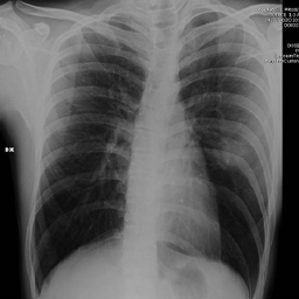

Class = COVID 



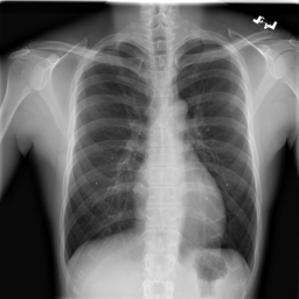

Class = Normal 



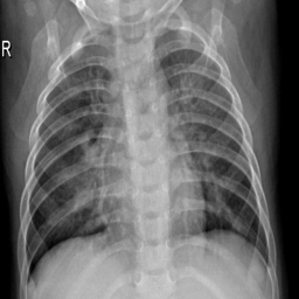

Class = Viral Pneumonia 



In [9]:
sampleset = RadiographyDataset("./Radiography_Data/train", transform=None)

image_1, label_1 = sampleset[1]
display(image_1)
print("Class =", sampleset.classes[label_1], "\n")

image_2, label_2 = sampleset[2893]
display(image_2)
print("Class =", sampleset.classes[label_2], "\n")

image_3, label_3 = sampleset[11047]
display(image_3)
print("Class =", sampleset.classes[label_3], "\n")

The network layout

In [10]:
sample_net = Net()
sample_net = sample_net.cuda()
summary(sample_net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]           9,248
             BLOCK-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
            Conv2d-5         [-1, 64, 112, 112]          36,928
             BLOCK-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                   [-1, 10]             650
Total params: 66,218
Trainable params: 66,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 55.13
Params size (MB): 0.25
Estimated Total Size (MB): 55.95
----------------------------------------------------------------


Transformation of images

In [11]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform the model
train_transform = transforms.Compose([
    transforms.Resize(256),                                # output: PIL Image of resolution(256, 256)
    transforms.RandomCrop(224),                            # output: PIL Image of resolution(224, 224)
    transforms.RandomHorizontalFlip(),                     # output: PIL Image of resolution(224, 224)
    transforms.ToTensor(),                                 # output: tensor, dtype = float32, shape = (3, 224, 224), range:[0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # output: same as before except range changes such that mean = 0, std = 1
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Load the dataset using DataLoader

In [12]:
#Load the dataset
trainset = RadiographyDataset("./Radiography_Data/train", transform=train_transform)
valset  = RadiographyDataset("./Radiography_Data/val", transform=val_transform)

batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
valloader  = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)

Start training

In [13]:
net = Net()
train_loss = train (net, trainloader, num_epochs=20)

[Epoch  1 Iter    32/95]: train_loss = 1.1570
[Epoch  1 Iter    64/95]: train_loss = 0.8233
[Epoch  1 Iter    95/95]: train_loss = 0.8245
[Epoch  2 Iter    32/95]: train_loss = 0.8085
[Epoch  2 Iter    64/95]: train_loss = 0.8057
[Epoch  2 Iter    95/95]: train_loss = 0.7898
[Epoch  3 Iter    32/95]: train_loss = 0.8163
[Epoch  3 Iter    64/95]: train_loss = 0.7942
[Epoch  3 Iter    95/95]: train_loss = 0.7749
[Epoch  4 Iter    32/95]: train_loss = 0.7619
[Epoch  4 Iter    64/95]: train_loss = 0.7926
[Epoch  4 Iter    95/95]: train_loss = 0.7460
[Epoch  5 Iter    32/95]: train_loss = 0.7302
[Epoch  5 Iter    64/95]: train_loss = 0.7532
[Epoch  5 Iter    95/95]: train_loss = 0.7506
[Epoch  6 Iter    32/95]: train_loss = 0.7622
[Epoch  6 Iter    64/95]: train_loss = 0.7268
[Epoch  6 Iter    95/95]: train_loss = 0.7686
[Epoch  7 Iter    32/95]: train_loss = 0.7282
[Epoch  7 Iter    64/95]: train_loss = 0.7093
[Epoch  7 Iter    95/95]: train_loss = 0.7012
[Epoch  8 Iter    32/95]: train_lo

In [66]:
# Release Cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [67]:
val_loss = fine_tune(net, valloader, num_epochs=20)

[Epoch  1 Iter     4/12]: val_loss = 0.5792
[Epoch  1 Iter     8/12]: val_loss = 0.5919
[Epoch  1 Iter    12/12]: val_loss = 0.6239
[Epoch  2 Iter     4/12]: val_loss = 0.5862
[Epoch  2 Iter     8/12]: val_loss = 0.6040
[Epoch  2 Iter    12/12]: val_loss = 0.6060
[Epoch  3 Iter     4/12]: val_loss = 0.6188
[Epoch  3 Iter     8/12]: val_loss = 0.6014
[Epoch  3 Iter    12/12]: val_loss = 0.5714
[Epoch  4 Iter     4/12]: val_loss = 0.5779
[Epoch  4 Iter     8/12]: val_loss = 0.6387
[Epoch  4 Iter    12/12]: val_loss = 0.5743
[Epoch  5 Iter     4/12]: val_loss = 0.5999
[Epoch  5 Iter     8/12]: val_loss = 0.5991
[Epoch  5 Iter    12/12]: val_loss = 0.5942
[Epoch  6 Iter     4/12]: val_loss = 0.6016
[Epoch  6 Iter     8/12]: val_loss = 0.5895
[Epoch  6 Iter    12/12]: val_loss = 0.6036
[Epoch  7 Iter     4/12]: val_loss = 0.6223
[Epoch  7 Iter     8/12]: val_loss = 0.5556
[Epoch  7 Iter    12/12]: val_loss = 0.6180
[Epoch  8 Iter     4/12]: val_loss = 0.5800
[Epoch  8 Iter     8/12]: val_lo

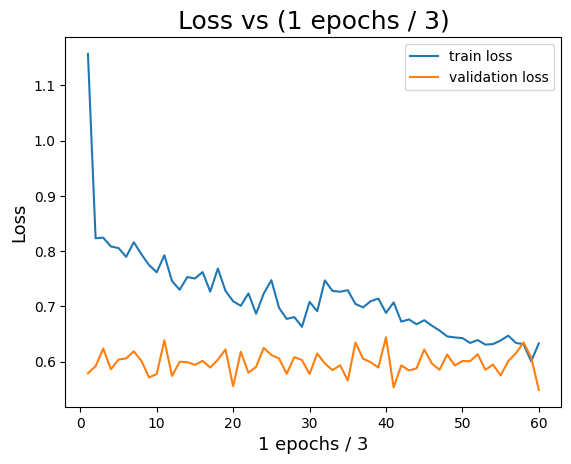

In [72]:
plot_loss(train_loss, val_loss)

In [ ]:
#plot_history_acc(train_acc, val_acc)

Evaluate model

In [24]:
# transform the model
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
testset = RadiographyDataset("./Radiography_Data/test", transform=test_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

In [25]:
evaluate(net, testloader)

Accuracy = 72.18%


def train(model, trainloader, valloader, num_epochs, lr=0.1, momentum=0.9, step_size=10, gamma=0.1):
    
    if torch.cuda.is_available():
      device = torch.device("cuda")
      
    else:
      device = torch.device("cpu")

    loss_iterations = int(np.ceil(len(trainloader)/3))
    train_history = []  # save the iter train loss
    val_history = []    # save the iter validation loss
    train_acc = []      # save the train accurarcy
    val_acc = []        # save the validation accurarcy

    # transfer model to GPU
    model = model.to(device)

    # variables
    best_loss = np.inf
    saturate_count = 0
    
    # train the network
    for e in range(num_epochs):    

        # set the optimizer. Use the SGD optimizer. Use the lr and momentum settings passed by the user
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        #running_loss
        running_loss = 0.0
        running_count = 0.0
        running_val_loss = 0.0
        running_val_count = 0.0

        # running_correct
        running_corrects = 0
        running_count = 0
        running_corrects_val = 0
        running_count_val = 0

        #----------------------------train---------------------------------------
        # set to training mode
        model.train()

        # for all batch samples
        for i, (inputs, labels) in enumerate(trainloader):

            # Clear all the gradient to zero
            optimizer.zero_grad()

            # transfer data to GPU
            if torch.cuda.is_available():
              inputs = inputs.to(device)
              labels = labels.to(device)

            # forward propagation to get h
            outs = model(inputs)

            # compute loss 
            loss = F.cross_entropy(outs, labels)

            # backpropagation to get gradients of all parameters
            loss.backward()

            # update parameters
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

            # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:                
                train_loss = running_loss / running_count
                train_history.append(train_loss)
                running_loss = 0. 
                running_count = 0.
                print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

        # Update the scheduler's counter at the end of each epoch
        scheduler.step()

        #-----------------------validation---------------------------------------
        # set to eval mode
        model.eval()

        for i, (inputs, labels) in enumerate(valloader):

            #labels = labels.reshape(-1, 1).float()

            # transfer data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward propagation to get h
            outs = model(inputs)
        
            # compute loss 
            loss_val = F.binary_cross_entropy(outs, labels)

            # get the loss
            running_val_loss += loss_val.item()
            running_val_count += 1

            # display the averaged loss value 
            if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:                
                val_loss = running_val_loss / running_val_count
                val_history.append(val_loss)
                running_val_loss = 0. 
                running_val_count = 0.
                print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: val_loss = {val_loss:.4f}')

        # create save model folder
        if not os.path.exists("./custom_models"):
          os.mkdir("custom_models") 

        # save the model       
        checkpoint_file = './custom_models/saved_model.pt'
        torch.save({
            'epoch': e,
            'loss': train_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_file)       
                
    print("Training completed.")
    return train_history, val_history